In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from tpot import TPOTClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost

%matplotlib inline

In [2]:
#leer la bd
df = pd.read_csv("../data/interim/9m churn con datos pers.csv")
df  = df.iloc[:,1:]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842516 entries, 0 to 842515
Data columns (total 22 columns):
CUSTOMER_ID        842516 non-null int64
9 meses            842516 non-null float64
8 meses            842516 non-null float64
7 meses            842516 non-null float64
6 meses            842516 non-null float64
5 meses            842516 non-null float64
4 meses            842516 non-null float64
3 meses            842516 non-null float64
2 meses            842516 non-null float64
1 meses            842516 non-null float64
Churn              842516 non-null int64
DATE_OF_BIRTH      827773 non-null object
GENDER             842128 non-null object
MARITAL_STATUS     762728 non-null object
EDUCATION          276967 non-null object
EDUCATION_LEVEL    25960 non-null object
OCCUPATION         514756 non-null object
CITY               645413 non-null object
LOCALITY           645413 non-null object
FECHA_PROCESO      842516 non-null object
edad               827773 non-null float64


# Modelo solo con 3 meses churn y no churn

In [3]:
df = df[ (df["1 meses"] == 0) & (df["2 meses"] == 0) & (df["3 meses"] == 0) & (df["4 meses"] > 0) | (df["1 meses"] > 0) & (df["2 meses"] > 0) & (df["3 meses"] > 0) & (df["Churn"] == 0)  ]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 551337 entries, 0 to 842514
Data columns (total 22 columns):
CUSTOMER_ID        551337 non-null int64
9 meses            551337 non-null float64
8 meses            551337 non-null float64
7 meses            551337 non-null float64
6 meses            551337 non-null float64
5 meses            551337 non-null float64
4 meses            551337 non-null float64
3 meses            551337 non-null float64
2 meses            551337 non-null float64
1 meses            551337 non-null float64
Churn              551337 non-null int64
DATE_OF_BIRTH      540345 non-null object
GENDER             551049 non-null object
MARITAL_STATUS     501643 non-null object
EDUCATION          176686 non-null object
EDUCATION_LEVEL    17892 non-null object
OCCUPATION         341625 non-null object
CITY               416311 non-null object
LOCALITY           416311 non-null object
FECHA_PROCESO      551337 non-null object
edad               540345 non-null float64


In [15]:
#Error
#este incluye churns de más de 4 meses (6 a 9)
#df = df[ (df["1 meses"] == 0) & (df["2 meses"] == 0) & (df["3 meses"] == 0) & (df["4 meses"] > 0) | (df["1 meses"] > 0) & (df["2 meses"] > 0) & (df["3 meses"] > 0)   ]
#df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 555227 entries, 0 to 842514
Data columns (total 22 columns):
CUSTOMER_ID        555227 non-null int64
9 meses            555227 non-null float64
8 meses            555227 non-null float64
7 meses            555227 non-null float64
6 meses            555227 non-null float64
5 meses            555227 non-null float64
4 meses            555227 non-null float64
3 meses            555227 non-null float64
2 meses            555227 non-null float64
1 meses            555227 non-null float64
Churn              555227 non-null int64
DATE_OF_BIRTH      544159 non-null object
GENDER             554937 non-null object
MARITAL_STATUS     505188 non-null object
EDUCATION          178158 non-null object
EDUCATION_LEVEL    18028 non-null object
OCCUPATION         344490 non-null object
CITY               419381 non-null object
LOCALITY           419381 non-null object
FECHA_PROCESO      555227 non-null object
edad               544159 non-null float64


In [4]:
df["Churn"].value_counts() / len(df)

0    0.952564
1    0.047436
Name: Churn, dtype: float64

## Testeando el modelo base

In [0]:
#Modelo base, predecir a todos los que tengan null en el último mes (4to) => churn
df["myChurnPred"] = 0
df.loc[df["4 meses"] == 0, "myChurnPred"] = 1

In [11]:
from sklearn.metrics import roc_auc_score

roc_auc_score(df["Churn"], df["myChurnPred"])

0.855390429914991

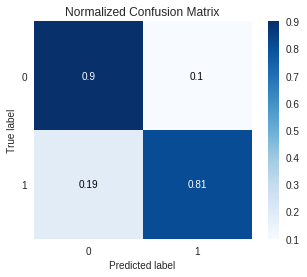

In [12]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(df["Churn"], df["myChurnPred"], normalize=True)

In [5]:
df.drop("DATE_OF_BIRTH", axis=1, inplace=True)
df.drop("FECHA_PROCESO", axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 551337 entries, 0 to 842514
Data columns (total 20 columns):
CUSTOMER_ID        551337 non-null int64
9 meses            551337 non-null float64
8 meses            551337 non-null float64
7 meses            551337 non-null float64
6 meses            551337 non-null float64
5 meses            551337 non-null float64
4 meses            551337 non-null float64
3 meses            551337 non-null float64
2 meses            551337 non-null float64
1 meses            551337 non-null float64
Churn              551337 non-null int64
GENDER             551049 non-null object
MARITAL_STATUS     501643 non-null object
EDUCATION          176686 non-null object
EDUCATION_LEVEL    17892 non-null object
OCCUPATION         341625 non-null object
CITY               416311 non-null object
LOCALITY           416311 non-null object
edad               540345 non-null float64
ModoPago           551337 non-null object
dtypes: float64(10), int64(2), object(8)
m

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

RANDOM_STATE=42
size = 0.5

In [7]:
df.Churn.value_counts() / len(df)

0    0.952564
1    0.047436
Name: Churn, dtype: float64

#Modelo que predice churn a 90 dias

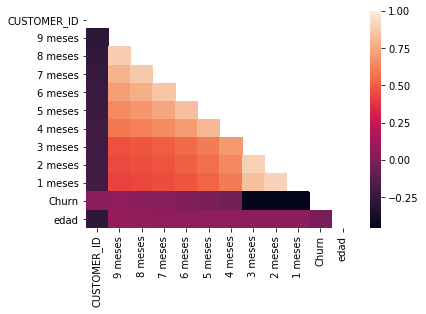

In [8]:
#viendo la correlación entre las variables
#https://seaborn.pydata.org/generated/seaborn.heatmap.html
corr = df.corr() #correlación entre variables
#creamos una mascara para no ver la diagonal superior (debido a que la matriz es espejada)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
#realizamos la grafica
sns.heatmap(corr, square=False, mask=mask)
plt.show()

In [9]:
#separo la bd train, test
from sklearn.model_selection import train_test_split
TEST_SIZE=0.20
RANDOM_STATE=42

# Formateando entrenamiento y testo
para luego armar validación dataset

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 551337 entries, 0 to 842514
Data columns (total 20 columns):
CUSTOMER_ID        551337 non-null int64
9 meses            551337 non-null float64
8 meses            551337 non-null float64
7 meses            551337 non-null float64
6 meses            551337 non-null float64
5 meses            551337 non-null float64
4 meses            551337 non-null float64
3 meses            551337 non-null float64
2 meses            551337 non-null float64
1 meses            551337 non-null float64
Churn              551337 non-null int64
GENDER             551049 non-null object
MARITAL_STATUS     501643 non-null object
EDUCATION          176686 non-null object
EDUCATION_LEVEL    17892 non-null object
OCCUPATION         341625 non-null object
CITY               416311 non-null object
LOCALITY           416311 non-null object
edad               540345 non-null float64
ModoPago           551337 non-null object
dtypes: float64(10), int64(2), object(8)
m

In [0]:
df.EDUCATION.nunique()

2

In [11]:
X = df.drop(["Churn", "CUSTOMER_ID", "LOCALITY", "edad", "OCCUPATION", "3 meses", "2 meses", "1 meses" ], axis=1)
y = df["Churn"]

In [12]:
X = pd.get_dummies(X)
X.head()

,9 meses,8 meses,7 meses,6 meses,5 meses,4 meses,GENDER_F,GENDER_M,MARITAL_STATUS_Casado,MARITAL_STATUS_Conviv,...,CITY_SANTIAGO DEL ESTERO,CITY_TIERRA DEL FUEGO,CITY_TUCUMAN,ModoPago_BA,ModoPago_CC,ModoPago_Mix,ModoPago_PP,ModoPago_SJ,ModoPago_TA,ModoPago_TM
0,1.0,1.0,1.0,1.0,1.0,1.0,0,1,1,0,...,0,0,0,0,1,0,0,0,0,0
1,2.0,2.0,2.0,2.0,2.0,2.0,0,1,1,0,...,0,0,0,0,1,0,0,0,0,0
2,1.0,1.0,1.0,1.0,1.0,1.0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1.0,1.0,1.0,1.0,1.0,1.0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1.0,1.0,1.0,1.0,1.0,1.0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0


In [0]:
bd_dummy = pd.concat([X, df[["CUSTOMER_ID", "Churn", "3 meses",	"2 meses",	"1 meses","LOCALITY", "OCCUPATION"] ]], axis=1)
bd_dummy.to_csv("9m churn con datos pers dummies.csv")

In [0]:
files.download("9m churn con datos pers dummies.csv")

In [13]:
X = X.astype("uint8")
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 551337 entries, 0 to 842514
Data columns (total 54 columns):
9 meses                           551337 non-null uint8
8 meses                           551337 non-null uint8
7 meses                           551337 non-null uint8
6 meses                           551337 non-null uint8
5 meses                           551337 non-null uint8
4 meses                           551337 non-null uint8
GENDER_F                          551337 non-null uint8
GENDER_M                          551337 non-null uint8
MARITAL_STATUS_Casado             551337 non-null uint8
MARITAL_STATUS_Conviv             551337 non-null uint8
MARITAL_STATUS_Divorciado         551337 non-null uint8
MARITAL_STATUS_No Corresp         551337 non-null uint8
MARITAL_STATUS_Separado           551337 non-null uint8
MARITAL_STATUS_Soltero            551337 non-null uint8
MARITAL_STATUS_Union Civ          551337 non-null uint8
MARITAL_STATUS_Viudo              551337 non-null

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [15]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110268 entries, 16136 to 473258
Data columns (total 54 columns):
9 meses                           110268 non-null uint8
8 meses                           110268 non-null uint8
7 meses                           110268 non-null uint8
6 meses                           110268 non-null uint8
5 meses                           110268 non-null uint8
4 meses                           110268 non-null uint8
GENDER_F                          110268 non-null uint8
GENDER_M                          110268 non-null uint8
MARITAL_STATUS_Casado             110268 non-null uint8
MARITAL_STATUS_Conviv             110268 non-null uint8
MARITAL_STATUS_Divorciado         110268 non-null uint8
MARITAL_STATUS_No Corresp         110268 non-null uint8
MARITAL_STATUS_Separado           110268 non-null uint8
MARITAL_STATUS_Soltero            110268 non-null uint8
MARITAL_STATUS_Union Civ          110268 non-null uint8
MARITAL_STATUS_Viudo              110268 non-

In [16]:
print("train: {} - test: {}".format(len(X_train), len(X_test)))

train: 441069 - test: 110268


In [17]:
#distrib de churn
np.sum(y_train) / len(y_train)

0.04726698090321469

In [18]:
from sklearn.metrics import roc_auc_score

## TPOT

In [0]:


tpot = TPOTClassifier(generations=5, population_size=20, random_state=RANDOM_STATE, verbosity=2, max_time_mins=80, n_jobs=-1, scoring="roc_auc")
tpot

TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
        disable_update_check=False, early_stop=None, generations=5,
        max_eval_time_mins=5, max_time_mins=80, memory=None,
        mutation_rate=0.9, n_jobs=-1, offspring_size=None,
        periodic_checkpoint_folder=None, population_size=20,
        random_state=42, scoring='roc_auc', subsample=1.0, use_dask=False,
        verbosity=2, warm_start=False)

In [0]:
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

RuntimeError: ignored

In [0]:
y_pred = tpot.predict(X_test)


In [0]:

roc_auc_score(y_test, y_pred)

0.90582903065867

In [0]:
for p, r in zip(y_pred[:40],y_test[:40]):
  print(p,r)

0 0
0 0
0 0
0 0
0 0
1 1
0 0
0 0
1 1
0 0
0 0
0 0
0 0
0 0
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 1
0 0
0 0
0 1
0 0
1 1
0 0
0 1
0 0
0 0
1 1
0 0
0 0
0 0
0 0
0 0


In [0]:
from sklearn.metrics import confusion_matrix

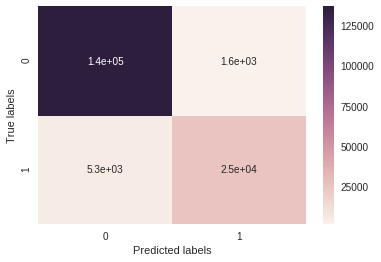

In [0]:
ax= plt.subplot()
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 


In [0]:
cm 

array([[136704,   1612],
       [  5301,  24887]])

In [0]:
import scikitplot as skplt

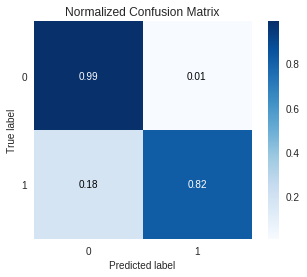

In [0]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

In [0]:
ypp = tpot.predict_proba(X_test)
ypp

array([[0.9901008 , 0.0098992 ],
       [1.        , 0.        ],
       [0.98959239, 0.01040761],
       ...,
       [0.86684559, 0.13315441],
       [0.97969977, 0.02030023],
       [0.86684559, 0.13315441]])

In [0]:
roc_auc_score(y_test, ypp[:,1])

0.9699511222438081

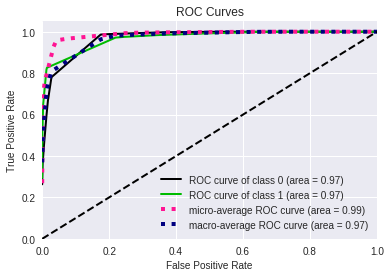

In [0]:
import scikitplot as skplt

skplt.metrics.plot_roc(y_test, ypp)

In [0]:
tpot.fitted_pipeline_

Pipeline(memory=Memory(cachedir='model/joblib'),
     steps=[('zerocount', ZeroCount()), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=0.4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=12, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [0]:
tpot.export("4.1.b - Modelo (3m pred) - 9m tpot full dataset thebox - rocauc 0.90.py")
!ls

4.1.b - Modelo (3m pred) - 9m tpot full dataset thebox - rocauc 0.90.py
4.1 - Modelo (3m pred) - 9m tpot thebox - rocauc 0.90.pkl
4.1 - Modelo (3m pred) - 9m tpot thebox - rocauc 0.90.py
6m churn.csv
9m churn.csv
dataset 6m churn last m sample.csv
model
sample_data


In [0]:
from google.colab import files

files.download("4.1.b - Modelo (3m pred) - 9m tpot full dataset thebox - rocauc 0.90.py")

In [0]:
from sklearn.externals import joblib

## RANDOM FOREST MODEL

### Modelo 1 = equal weights

In [19]:
from sklearn.ensemble import RandomForestClassifier
# Create a random forest Classifier. By convention, clf means 'Classifier'
clf = RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE)
clf


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [20]:
# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
clf.fit(X, y)

y_pred = clf.predict(X_test)

roc_auc_score(y_test, y_pred)

0.513727937863262

/home/seba/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


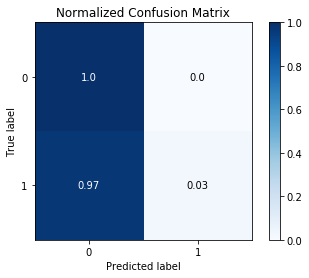

In [21]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

#### Feature Importance

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

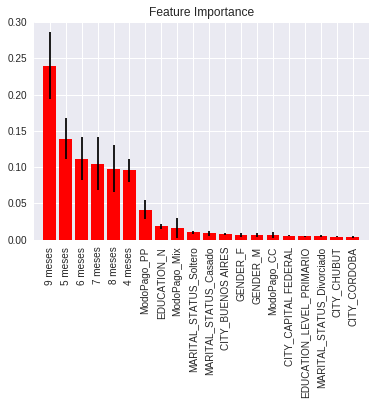

In [53]:
import scikitplot as skplt

skplt.estimators.plot_feature_importances(clf, feature_names=X.columns)
plt.xticks(rotation=90)

In [0]:
ypp = clf.predict_proba(X_test)

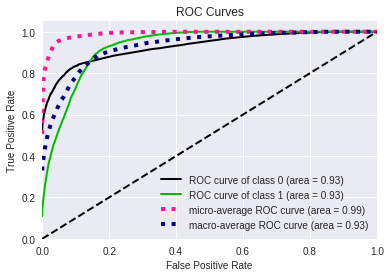

In [55]:
import scikitplot as skplt

skplt.metrics.plot_roc(y_test, ypp)


### Modelo 2 = differential weights

In [22]:
class_weight = dict({0:1, 1:15})

clf_w = RandomForestClassifier(class_weight=class_weight, n_jobs=-1, random_state=RANDOM_STATE)
clf_w

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 15},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [23]:
# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
clf_w.fit(X, y)

y_pred_w = clf_w.predict(X_test)

roc_auc_score(y_test, y_pred_w)

0.8545529615871194

/home/seba/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


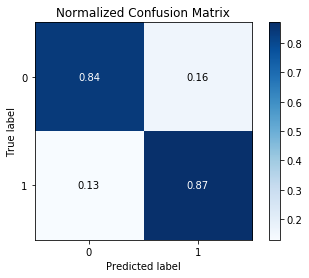

In [24]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_pred_w, normalize=True)

/home/seba/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


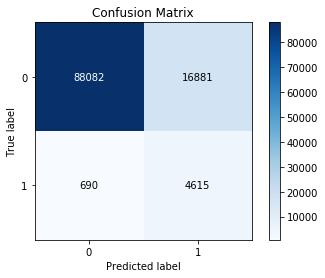

In [25]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_w, normalize=0)

### Optimización de modelo

In [85]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
param_range_fl = [1.0, 0.5, 0.1]
class_weight_range = [{0:1, 1:5},{0:1, 1:10},{0:1, 1:15},{0:1, 1:20}]
#param_range_fl = np.power(10., np.arange(-4, 4))

grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],
		'clf__min_samples_leaf': param_range,
		'clf__max_depth': param_range,
		'clf__min_samples_split': param_range[1:],
    'class_weight' : class_weight_range}]

pipe_rf = Pipeline([('scl', StandardScaler()),
			('clf', RandomForestClassifier(random_state=RANDOM_STATE))])

# Construct grid searches
jobs = -1
metric = "roc_auc"
cv = 5

#refit=True, entrena el mejor modelo obtenido con todo el dataset! :D
#verbose => mientras mayor el número, más info va mostrando.
gs_rf = GridSearchCV(estimator=pipe_rf,
			param_grid=grid_params_rf,
			scoring=metric,
      refit=True,
			cv=cv, 
			n_jobs=jobs)
gs_rf

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0...timators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'clf__criterion': ['gini', 'entropy'], 'clf__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'clf__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'clf__min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'class_weight': [{0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 15}, {0: 1, 1: 20}]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [0]:
# Fit grid search	
gs_rf.fit(X_train, y_train)
# Best params
print('Best params: %s' % gs_rf.best_params_)
# Best training data roc auc
print('Best training roc auc: %.3f' % gs_rf.best_score_)
# Predict on test data with best params
y_pred_gs_rf = gs_rf.predict(X_test)
# Test data roc auc of model with best params
print('Test set roc auc score for best params: %.3f ' % roc_auc_score(y_test, y_pred_gs_rf))

#### Feature Importance

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

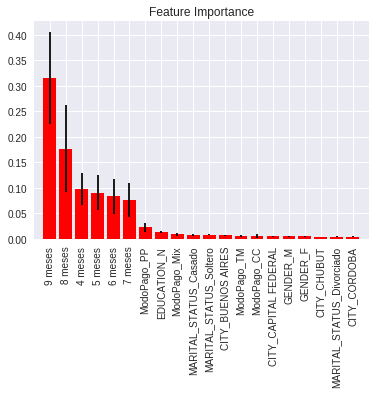

In [62]:
import scikitplot as skplt

skplt.estimators.plot_feature_importances(clf_w, feature_names=X.columns)
plt.xticks(rotation=90)

In [0]:
ypp_w = clf_w.predict_proba(X_test)

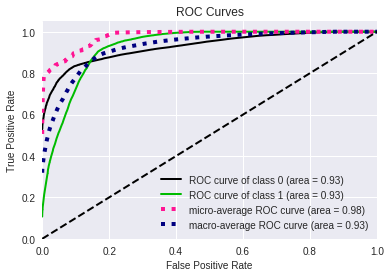

In [58]:
import scikitplot as skplt

skplt.metrics.plot_roc(y_test, ypp_w)


#### Ver como son los registros que predice True churn

In [26]:
df_int = X_test.copy(deep=True)
df_int["Churn"] =  y_test
df_int["pred"] = y_pred_w
df_int.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110268 entries, 16136 to 473258
Data columns (total 56 columns):
9 meses                           110268 non-null uint8
8 meses                           110268 non-null uint8
7 meses                           110268 non-null uint8
6 meses                           110268 non-null uint8
5 meses                           110268 non-null uint8
4 meses                           110268 non-null uint8
GENDER_F                          110268 non-null uint8
GENDER_M                          110268 non-null uint8
MARITAL_STATUS_Casado             110268 non-null uint8
MARITAL_STATUS_Conviv             110268 non-null uint8
MARITAL_STATUS_Divorciado         110268 non-null uint8
MARITAL_STATUS_No Corresp         110268 non-null uint8
MARITAL_STATUS_Separado           110268 non-null uint8
MARITAL_STATUS_Soltero            110268 non-null uint8
MARITAL_STATUS_Union Civ          110268 non-null uint8
MARITAL_STATUS_Viudo              110268 non-

In [28]:
df_int[df_int.Churn == 1]

,9 meses,8 meses,7 meses,6 meses,5 meses,4 meses,GENDER_F,GENDER_M,MARITAL_STATUS_Casado,MARITAL_STATUS_Conviv,...,CITY_TUCUMAN,ModoPago_BA,ModoPago_CC,ModoPago_Mix,ModoPago_PP,ModoPago_SJ,ModoPago_TA,ModoPago_TM,Churn,pred
525216,1,1,1,1,1,1,0,1,1,0,...,0,1,0,0,0,0,0,0,1,1
207048,1,1,1,1,1,1,1,0,0,0,...,0,0,1,0,0,0,0,0,1,1
803630,1,1,1,1,1,1,0,1,1,0,...,0,0,0,1,0,0,0,0,1,1
281754,0,1,1,1,1,1,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
680513,1,1,1,1,1,1,1,0,1,0,...,0,0,0,1,0,0,0,0,1,1
607822,1,1,1,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,1,1,1
696679,1,1,1,1,1,1,0,1,0,0,...,0,0,0,1,0,0,0,0,1,1
795158,0,1,1,1,1,1,0,1,1,0,...,0,0,0,1,0,0,0,0,1,0
156489,1,1,1,1,1,1,0,1,0,0,...,0,0,1,0,0,0,0,0,1,1
645069,1,1,1,1,1,1,1,0,1,0,...,0,0,0,1,0,0,0,0,1,1


## MULTIPLES MODELOS RASCKHA FLOW

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn import svm

# Load and split the data
#X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=42)

# Construct some pipelines
pipe_lr = Pipeline([('scl', StandardScaler()),
			('clf', LogisticRegression(random_state=42))])

pipe_lr_pca = Pipeline([('scl', StandardScaler()),
			('pca', PCA(n_components=2)),
			('clf', LogisticRegression(random_state=42))])

pipe_rf = Pipeline([('scl', StandardScaler()),
			('clf', RandomForestClassifier(random_state=42))])

pipe_rf_pca = Pipeline([('scl', StandardScaler()),
			('pca', PCA(n_components=2)),
			('clf', RandomForestClassifier(random_state=42))])

pipe_svm = Pipeline([('scl', StandardScaler()),
			('clf', svm.SVC(random_state=42))])

pipe_svm_pca = Pipeline([('scl', StandardScaler()),
			('pca', PCA(n_components=2)),
			('clf', svm.SVC(random_state=42))])
			
# Set grid search params
param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#param_range_fl = [1.0, 0.5, 0.1]
param_range_fl = np.power(10., np.arange(-4, 4))

grid_params_lr = [{'clf__penalty': ['l1', 'l2'],
		'clf__C': param_range_fl,
		'clf__solver': ['liblinear']}] 

grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],
		'clf__min_samples_leaf': param_range,
		'clf__max_depth': param_range,
		'clf__min_samples_split': param_range[1:]}]

grid_params_svm = [{'clf__kernel': ['linear', 'rbf'], 
		'clf__C': param_range}]

# Construct grid searches
jobs = -1
metric = "roc_auc"
cv = 5

gs_lr = GridSearchCV(estimator=pipe_lr,
			param_grid=grid_params_lr,
			scoring=metric,
      refit=True,
			cv=cv) 
			
gs_lr_pca = GridSearchCV(estimator=pipe_lr_pca,
			param_grid=grid_params_lr,
			scoring=metric,
      refit=True,
			cv=cv)
			
gs_rf = GridSearchCV(estimator=pipe_rf,
			param_grid=grid_params_rf,
			scoring=metric,
      refit=True,
			cv=cv, 
			n_jobs=jobs)

gs_rf_pca = GridSearchCV(estimator=pipe_rf_pca,
			param_grid=grid_params_rf,
			scoring=metric,
      refit=True,
			cv=cv, 
			n_jobs=jobs)

gs_svm = GridSearchCV(estimator=pipe_svm,
			param_grid=grid_params_svm,
			scoring=metric,
      refit=True,
			cv=cv,
			n_jobs=jobs)

gs_svm_pca = GridSearchCV(estimator=pipe_svm_pca,
			param_grid=grid_params_svm,
			scoring=metric,
      refit=True,
			cv=cv,
			n_jobs=jobs)

# List of pipelines for ease of iteration
grids = [gs_lr, gs_lr_pca, gs_rf, gs_rf_pca, gs_svm, gs_svm_pca]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'Logistic Regression', 1: 'Logistic Regression w/PCA', 
		2: 'Random Forest', 3: 'Random Forest w/PCA', 
		4: 'Support Vector Machine', 5: 'Support Vector Machine w/PCA'}


In [0]:
# Fit the grid search objects
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in tqdm(enumerate(grids)):

  if(idx < 4):
    continue

  print('\nEstimator: %s' % grid_dict[idx])	
  # Fit grid search	
  gs.fit(X_train, y_train)
  # Best params
  print('Best params: %s' % gs.best_params_)
  # Best training data roc auc
  print('Best training roc auc: %.3f' % gs.best_score_)
  # Predict on test data with best params
  y_pred = gs.predict(X_test)
  # Test data roc auc of model with best params
  print('Test set roc auc score for best params: %.3f ' % roc_auc_score(y_test, y_pred))
  # Track best (highest test roc auc) model
  if roc_auc_score(y_test, y_pred) > best_acc:
    best_acc = roc_auc_score(y_test, y_pred)
    best_gs = gs
    best_clf = idx
print('\nClassifier with best test set roc auc: %s' % grid_dict[best_clf])

Performing model optimizations...


NameError: ignored

Best params: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best training roc auc: 0.912
Test set roc auc score for best params: 0.870 


---
Estimator: Logistic Regression w/PCA
Best params: {'clf__C': 10.0, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best training roc auc: 0.582
Test set roc auc score for best params: 0.500 


---



